# Lettura Icone da Display

Il progetto vuole raggiungere lo scopo di catturare l'immagine di un display e identificare lo stato(on/off) delle icone che ne compongono l'interfaccia.  
L'applicazione vorrebbe essere implementata in un sistema di collaudo in cui il display viene inserito in un banco per testarne la cprretta operatività in uscita dalla produzione.  
Al momento dello studio per questo progetto il banco di collaudo era controllato da un interprete che interpretava i comandi di un linguaggio costruito ad hoc in azienda per i collaudi.  
Queste linee di codice verificano l'effetuabilità dell'applicazione, mentre l'implementazione dovrà essere fatta in un linguaggio che consenta la creazione di eseguibili: in quanto il linguaggio dell'interprete(al momento di questo studio) non è in grado di lanciare script in python. Anche se lo fosse, alcuni test mi portano a credere che i tempi necessari all'esecuzione dello script in questo linguaggio siano troppo lunghi per il funzionamento ottimale del collaudo.

## Come?

### Cattura 

Ottenere una immagine di modo che possa essere usata per la creazione e la ricerca delle immagini template che rappresentano le icone.

### Creazione Templates

Creare le immagini template delle icone

### Matching

Fare il matching delle immagini template sull'immagine ottenuta

In [2]:
# importo le librerie che mi serviranno durante il progetto
import numpy as np
import pandas
import os
import sys
import csv
import pathlib
import cv2
import matplotlib.pyplot as plt

_cv2_ è il modulo della libreria OpenCV. [OpenCV#4.6.0](https://docs.opencv.org/4.6.0/)  
_numpy_, _pandas_ e _matplotlib_ sono due moduli molto utilizzati nelle datascience perché mettono a disposizione molte funzioni utili per analizzare e modificare una grande varietà di dati. [numpy#1.22.4](https://numpy.org/doc/1.22/), [pandas#1.4.2](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html), [matplotlib#3.5.2](https://matplotlib.org/stable/users/index.html)  
_csv_ è una libreria per la gestione di input e output per file .csv [Lib/csv.py](https://docs.python.org/3/library/csv.html)  
_sys_, _os_ e _pathlib_ verranno utilizzati per gestire i percorsi dei dati di interesse. [sys](https://docs.python.org/3/library/sys.html), [Lib/os.py](https://docs.python.org/3/library/os.html), [Lib/pathlib.py](https://docs.python.org/3.9/library/pathlib.html)   

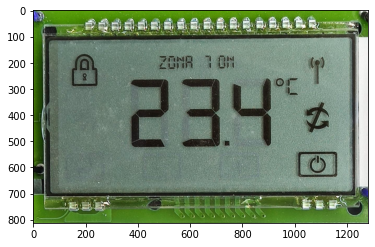

In [3]:
# lettura immagine da file

image = cv2.imread('images/pcb.jpg')
if image is None:
    print("Immagine non caricata")
else: 
    plt.imshow(image)
    plt.show

# cv2.imshow('image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Usando la funzione "imread" di openCV posso caricare una immagine da un file. [reference](https://docs.opencv.org/4.6.0/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56)  
Nel caso in cui volessi catturare il frame da una videocamera, posso utilizzare la funzione "VideoCapture". [reference](https://docs.opencv.org/4.6.0/d8/dfe/classcv_1_1VideoCapture.html)  
  
Per mostrare l'immagine ho usato la funzione "imshow" di "matplotlib.pyplot" invece di quella di openCV perché ritengo sia più comprensibile inserirla nella struttura del notebook piuttosto che creare una finestra esterna.

<function matplotlib.pyplot.show(close=None, block=None)>

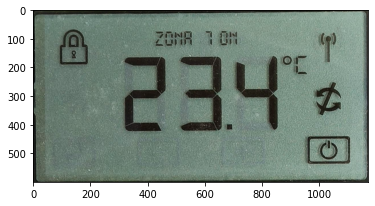

In [4]:
# ritaglio l'immagine
cropped_img = image[100:700, 55:1225]

plt.imshow(cropped_img)
plt.show

# cv2.imshow('cropped_img', cropped_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

ho tagliato l'immagine "a mano" perché il pcb è sprovvisto di cornice e questo rende difficile identificare l'area del display con l'edge-detection.  
teoricamente, nel suo banco di collaudo, il dispositivo sarebbe all'interno di una cornice per effetuare i test e dovrebbe essere possibile definirne il contorno come verrà fatto di seguito con le icone.

<function matplotlib.pyplot.show(close=None, block=None)>

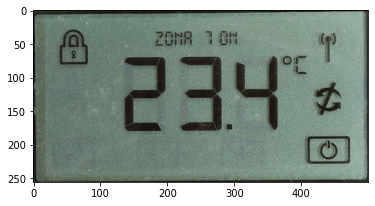

In [5]:
# ridimensiono l'immagine
h, w = cropped_img.shape[:2]
width = 500
r = width/w
dim = (width, int(r*h))
resized_img = cv2.resize(cropped_img, dim , interpolation=cv2.INTER_AREA)

plt.imshow(resized_img)
plt.show

# cv2.imshow('resized_img', resized_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[reference](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)

<function matplotlib.pyplot.show(close=None, block=None)>

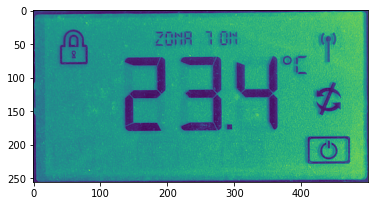

In [6]:
# porto l'immagine in scala di grigi
gray = cv2.cvtColor(resized_img,cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.show

# cv2.imshow('gray', gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[reference](https://docs.opencv.org/4.6.0/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)

<function matplotlib.pyplot.show(close=None, block=None)>

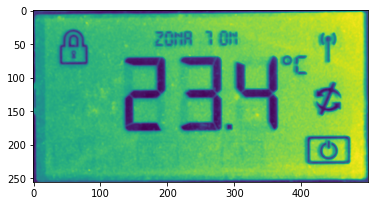

In [7]:
# applico un filtro gaussiano per addolcire i contrasti
blurred = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blurred)
plt.show

# cv2.imshow('blurred', blurred)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[reference](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

<function matplotlib.pyplot.show(close=None, block=None)>

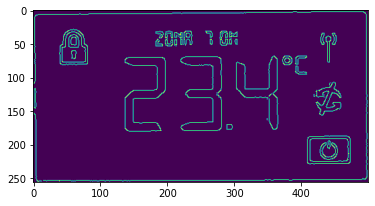

In [8]:
# applico la funzione Canny edge per trovare i contorni
edged = cv2.Canny(blurred, 50, 150, 255)

plt.imshow(edged)
plt.show

# cv2.imshow('edged', edged)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[reference](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)

<function matplotlib.pyplot.show(close=None, block=None)>

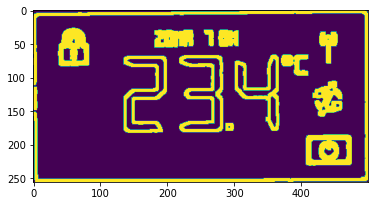

In [9]:
# applico un filtro di apertura per enfatizzare i contorni
kernel = np.ones((5,5), np.uint8)
dilation = cv2.dilate(edged.copy(), kernel, iterations=1)

plt.imshow(dilation)
plt.show

# cv2.imshow('dilatate', dilatate)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[reference](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c)

<function matplotlib.pyplot.show(close=None, block=None)>

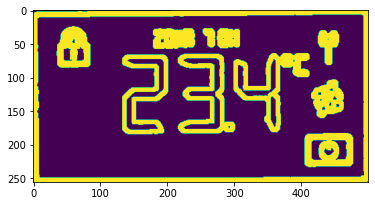

In [10]:
# Trovo i contorni e li memorizzo
draw_cnts = dilation.copy()

contours, hierarchy = cv2.findContours(draw_cnts, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
i = 0

# verifico i contorni disegnandoli su una immagine
for c in contours:
    cv2.drawContours(draw_cnts, contours, i, (255,0,0), thickness=3)
    # print("colorato contorno n", i)
    i += 1

plt.imshow(draw_cnts)
plt.show

# cv2.imshow('draw_cnts', draw_cnts)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


find contours [reference](https://docs.opencv.org/4.6.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)  
draw contours [reference](https://docs.opencv.org/4.6.0/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc)

<function matplotlib.pyplot.show(close=None, block=None)>

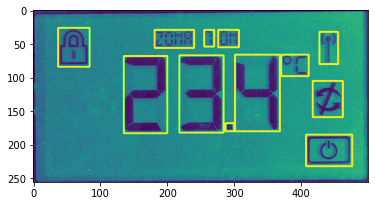

In [11]:
# usando i contorni trovati, identifico le icone sul display
img_with_icons = gray.copy()

icons = []
icons_bounds = []

# scorro i contorni trovati
for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    # elimino i contorni sui bordi
    if (5 < x < 495) and (5 < y < 245) :
        # elimino i contorni troppo piccoli
        if (w > 8) and (h > 7):
            # verifico che i contorni non siano troppo grandi(non sarebbe necessario qui)
            if h < 200:
                cv2.rectangle(img_with_icons,(x,y),(x+w,y+h),(255,0,0),2)
                bound = (x,y,w,h)
                # salvo i contorni delle icone icone in una lista
                icons.append(c)
                # faccio la stessa cosa con le loro coordinate
                icons_bounds.append(bound)


plt.imshow(img_with_icons)
plt.show

# cv2.imshow('img_with_icons', img_with_icons)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

bounding rect [reference](https://docs.opencv.org/4.6.0/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7)  
rectangle [reference](https://docs.opencv.org/4.6.0/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9)

In [12]:
# definisco alcuni path per scrivere e leggere i file dalla cartella del progetto e per salvare le icone
root = os.path.dirname(os.path.abspath(sys.argv[0]))
p = pathlib.Path(root)
p = p.parent.parent.parent
p_icons = os.path.join(p,'images','icons')
p_icons.replace('\\', '/')
print(p)
print(p_icons)
   

c:\Users\1989z\Documents\2022-06-15_TM_progetto
c:\Users\1989z\Documents\2022-06-15_TM_progetto\images\icons


non ho perso troppo tempo su quale sistema sarebbe più efficiente come gestione del pathing per due motivazioni: 
- questo progetto serve come test e la lettura/scrittura di file, seppur importanti, non fanno parte dello studio
- come scritto all'inizio, nei test effettuati sembra che sia necessario migrare il codice su un altro linguaggio

In [13]:
# salvo le icone nella loro cartella e memorizzo un file .csv per tenere traccia delle loro coordinate
cont = 0
icons_legend = os.path.join(p_icons + '\\icons_legend.csv')
print(icons_legend)

if os.path.exists(icons_legend):
    os.remove(icons_legend)

with open(icons_legend, 'w', newline='') as i_l:
    csv_writer = csv.writer(i_l)
    header = ['id', 'x', 'y', 'w', 'h']
    csv_writer = csv.DictWriter(i_l, fieldnames=header)
    csv_writer.writeheader()

    for ib in icons_bounds:
        name = "icona_"+str(cont).zfill(3)+".jpg"
        roi = resized_img.copy()[ib[1]:ib[1]+ib[3], ib[0]:ib[0]+ib[2]]
        i_p = os.path.join(p_icons + '/' + name)
        cv2.imwrite(i_p, roi)
        row = {'id' : name, 'x' : str(ib[0]), 'y' : str(ib[1]), 'w' : str(ib[2]), 'h' : str(ib[3])} 
        csv_writer.writerow(row)
        cont += 1


c:\Users\1989z\Documents\2022-06-15_TM_progetto\images\icons\icons_legend.csv


[reference](https://docs.opencv.org/4.6.0/d4/da8/group__imgcodecs.html#gabbc7ef1aa2edfaa87772f1202d67e0ce)

In [14]:
# preparo alcune variabili per effettuare il matching
thresh = 0.6
csv_reader = pandas.read_csv(icons_legend)
main_dir = p
res_path = os.path.join(main_dir,'results.txt')
print(res_path)


c:\Users\1989z\Documents\2022-06-15_TM_progetto\results.txt


non sono sicuro di come dovrei approcciare la variabile di soglia(__thresh__) affinché non sia un numero magico.

<function matplotlib.pyplot.show(close=None, block=None)>

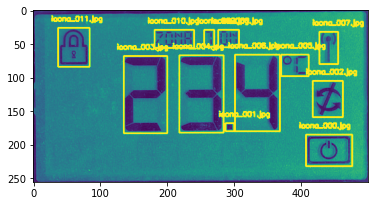

In [27]:
# effettuo il matching dell'icona sulla'immagine
final = gray.copy()
# inizializzo un contenitore con le immagini res
s_res= []
# inizializzo un contatore per leggere le righe del file .csv
cnt = 0
if os.path.exists(res_path):
    os.remove(res_path)
# scorro i file nella cartella "icons"
for images in os.listdir(p_icons):
    # verifico che siano immagini
    if(images.endswith(".jpg")):
        i_p = os.path.join(p_icons + '\\' + images)
        # leggo l'icona e la converto in scala di grigi
        icona = cv2.imread(i_p)
        icona = cv2.cvtColor(icona,cv2.COLOR_BGR2GRAY)
        # verifico che le icone corrispondano alla lista del file .csv
        if images == csv_reader['id'] [cnt]:
            # print(csv_reader['id'][cnt])
            x,y,w,h = (csv_reader['x'][cnt],csv_reader['y'][cnt],csv_reader['w'][cnt],csv_reader['h'][cnt])
            # print( x, y, w, h)

            # ottengo il risultato del matching dell'icona, sono coordinate sull'immagine
            res = cv2.matchTemplate(final.copy(), icona, cv2.TM_CCOEFF_NORMED)
            # print(res)
            cv2.rectangle(res, (x,y), (x+w, y+h), 255, 2)
            s_res.append(res)
            # dalle coordinate estraggo quelle in cui il matching è superiore alla soglia
            locations = np.where(res>=thresh)
            locations = list(zip(*locations[::-1]))
            # print('locations')
            # print(locations)

            # verifico che le coordinate esistano
            if len(locations) != 0:
                # scorro e controllo che ci sia una corrispondenza con le coordinate che ho salvato nel file .csv
                for loc in locations:
                    if x == loc[0] and y == loc[1]:
                        # print("trovato " + images)

                        # scrivo il risultato su un file di testo
                        found = open(res_path, "a")
                        found.write("trovato " + images + '\r\n')
                        found.close() 
                        # disegno un rettangolo intorno all'icona trovata e vi scrivo il nome per verificare che sia l'icona corretta
                        cv2.rectangle(final, (x,y), (x+w, y+h), 255, 2)
                        cv2.putText(final, images, (x-10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 255, 2)

    if cnt < 12:
        cnt += 1



plt.imshow(final)
plt.show

# cv2.imshow('final', final)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [33]:
# controllo immagini res
# plt.imshow(s_res[3])
# plt.show

for img in s_res:
    cv2.imshow('img', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

match template [reference](https://docs.opencv.org/4.6.0/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be)  
put text [reference](https://docs.opencv.org/4.6.0/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

i risultati dei match delle icone sono salvati in un file .txt in previsione dell'utilizzo con l'interprete, per facilitare i test

<function matplotlib.pyplot.show(close=None, block=None)>

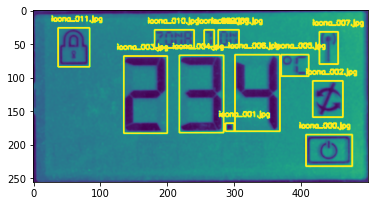

In [16]:
# matching con l'immagine del display esposta ad un filtro gaussiano
final_blurred = blurred.copy()
thresh_blurred = 0.4
res_path_blurred = os.path.join(main_dir,'results_blurred.txt')
cnt = 0
if os.path.exists(res_path_blurred):
    os.remove(res_path_blurred)
for images in os.listdir(p_icons):
    if(images.endswith(".jpg")):
        i_p = os.path.join(p_icons + '\\' + images)
        icona = cv2.imread(i_p)
        icona = cv2.cvtColor(icona,cv2.COLOR_BGR2GRAY)
        if images == csv_reader['id'] [cnt]:
            
            # print(csv_reader['id'][cnt])
            x,y,w,h = (csv_reader['x'][cnt],csv_reader['y'][cnt],csv_reader['w'][cnt],csv_reader['h'][cnt])
            # print( x, y, w, h)
            res_blurred = cv2.matchTemplate(final_blurred.copy(), icona, cv2.TM_CCOEFF_NORMED)
            # print(res)
            locations_blurred = np.where(res_blurred>=thresh_blurred)
            locations_blurred = list(zip(*locations_blurred[::-1]))
            # print('locations')
            # print(locations)
            if len(locations_blurred) != 0:
                for loc in locations_blurred:
                    if x == loc[0] and y == loc[1]:
                        # print("trovato " + images)
                        found = open(res_path_blurred, "a")
                        found.write("trovato " + images + '\r\n')
                        found.close()  
                        cv2.rectangle(final_blurred, (x,y), (x+w, y+h), 255, 2)
                        cv2.putText(final_blurred, images, (x-10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 255, 2)

    if cnt < 12:
        cnt += 1



plt.imshow(final_blurred)
plt.show

# cv2.imshow('final', final_blurred )
# cv2.waitKey(0)
# cv2.destroyAllWindows()

<function matplotlib.pyplot.show(close=None, block=None)>

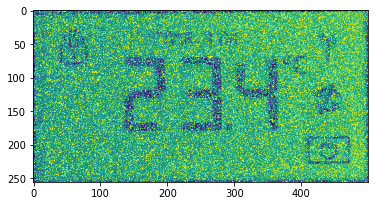

In [17]:
# inserisco del rumore sale e pepe nell'immagine di base
snp = gray.copy()

if len(snp.shape) == 2:
    probs = np.random.random(snp.shape[:2])
    snp[probs < (probs/2)] = 0
    snp[probs > 1 - (probs/2)] = 255

plt.imshow(snp)
plt.show

# cv2.imshow('snp', snp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

c:\Users\1989z\Documents\2022-06-15_TM_progetto\results_snp.txt


<function matplotlib.pyplot.show(close=None, block=None)>

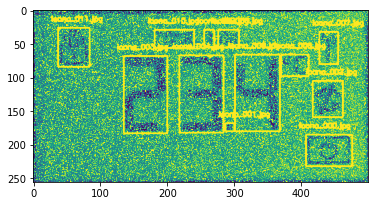

In [18]:
# effetto il matching sull'immagine sale e pepe
thresh_snp = 0.2
res_snp_path = os.path.join(main_dir,'results_snp.txt')
print(res_snp_path)
cnt = 0
if os.path.exists(res_snp_path):
    os.remove(res_snp_path)
for images in os.listdir(p_icons):
    if(images.endswith(".jpg")):
        i_p = os.path.join(p_icons + '\\' + images)
        icona = cv2.imread(i_p)
        icona = cv2.cvtColor(icona,cv2.COLOR_BGR2GRAY)
        if images == csv_reader['id'] [cnt]:
            
            # print(csv_reader['id'][cnt])
            x,y,w,h = (csv_reader['x'][cnt],csv_reader['y'][cnt],csv_reader['w'][cnt],csv_reader['h'][cnt])
            # print( x, y, w, h)
            res_snp = cv2.matchTemplate(snp.copy(), icona, cv2.TM_CCOEFF_NORMED)
            # print(res)
            locations_snp = np.where(res_snp>=thresh_snp)
            locations_snp = list(zip(*locations_snp[::-1]))
            # print('locations')
            # print(locations)
            if len(locations_snp) != 0:
                for loc in locations_snp:
                    if x == loc[0] and y == loc[1]:
                        # print("trovato " + images)
                        found = open(res_snp_path, "a")
                        found.write("trovato " + images + '\r\n')
                        found.close()  
                        cv2.rectangle(snp, (x,y), (x+w, y+h), 255, 2)
                        cv2.putText(snp, images, (x-10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 255, 2)

    if cnt < 12:
        cnt += 1



plt.imshow(snp)
plt.show

# cv2.imshow('snp', snp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [19]:
snp_smoothed = cv2.GaussianBlur(snp, (5,5), 0)

c:\Users\1989z\Documents\2022-06-15_TM_progetto\results_snp__smoothed.txt


<function matplotlib.pyplot.show(close=None, block=None)>

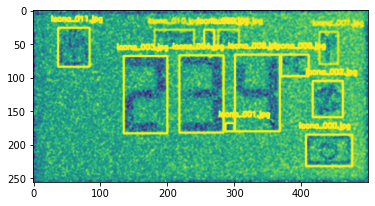

In [20]:
# effettuo il matching sull'immagine sale e pepe fatta passare in un filtro gaussiano
thresh_snp_smoothed = 0.6
res_snp_smoothed_path = os.path.join(main_dir,'results_snp__smoothed.txt')
print(res_snp_smoothed_path)
cnt = 0
if os.path.exists(res_snp_smoothed_path):
    os.remove(res_snp_smoothed_path)
for images in os.listdir(p_icons):
    if(images.endswith(".jpg")):
        i_p = os.path.join(p_icons + '\\' + images)
        icona = cv2.imread(i_p)
        icona = cv2.cvtColor(icona,cv2.COLOR_BGR2GRAY)
        if images == csv_reader['id'] [cnt]:
            
            # print(csv_reader['id'][cnt])
            x,y,w,h = (csv_reader['x'][cnt],csv_reader['y'][cnt],csv_reader['w'][cnt],csv_reader['h'][cnt])
            # print( x, y, w, h)
            res_snp_smoothed = cv2.matchTemplate(snp_smoothed.copy(), icona, cv2.TM_CCOEFF_NORMED)
            # print(res)
            locations_snp_smoothed = np.where(res_snp_smoothed>=thresh_snp_smoothed)
            locations_snp_smoothed = list(zip(*locations_snp_smoothed[::-1]))
            # print('locations')
            # print(locations)
            if len(locations_snp_smoothed) != 0:
                for loc in locations_snp_smoothed:
                    if x == loc[0] and y == loc[1]:
                        # print("trovato " + images)
                        found = open(res_snp_smoothed_path, "a")
                        found.write("trovato " + images + '\r\n')
                        found.close()  
                        cv2.rectangle(snp_smoothed, (x,y), (x+w, y+h), 255, 2)
                        cv2.putText(snp_smoothed, images, (x-10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 255, 2)

    if cnt < 12:
        cnt += 1



plt.imshow(snp_smoothed)
plt.show

# cv2.imshow('snp_smoothed', snp_smoothed)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

256 500
(125, 64) (375, 192)


<function matplotlib.pyplot.show(close=None, block=None)>

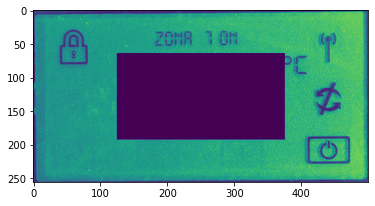

In [21]:
# inserisco una ostruzione nell'immagine
obstruct = gray.copy()
o_h, o_w = obstruct.shape
print(o_h, o_w)
r_start = (int((o_w/2)-(o_w/4)), int((o_h/2)-(o_h/4)))
r_end = (int((o_w/2)+(o_w/4)), int((o_h/2)+(o_h/4)))
print(r_start, r_end)
obstruct = cv2.rectangle(obstruct, r_start, r_end, (0,0,0), -1)

plt.imshow(obstruct)
plt.show

# cv2.imshow('obstruct', obstruct)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

c:\Users\1989z\Documents\2022-06-15_TM_progetto\results_obstruct.txt


<function matplotlib.pyplot.show(close=None, block=None)>

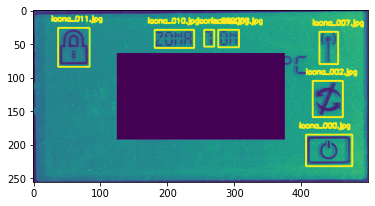

In [22]:
# effettuo il matching sull'immagine ostruita
thresh_obstruct = 0.6
res_obstruct_path = os.path.join(main_dir,'results_obstruct.txt')
print(res_obstruct_path)
cnt = 0
if os.path.exists(res_obstruct_path):
    os.remove(res_obstruct_path)
for images in os.listdir(p_icons):
    if(images.endswith(".jpg")):
        i_p = os.path.join(p_icons + '\\' + images)
        icona = cv2.imread(i_p)
        icona = cv2.cvtColor(icona,cv2.COLOR_BGR2GRAY)
        if images == csv_reader['id'] [cnt]:
            
            # print(csv_reader['id'][cnt])
            x,y,w,h = (csv_reader['x'][cnt],csv_reader['y'][cnt],csv_reader['w'][cnt],csv_reader['h'][cnt])
            # print( x, y, w, h)
            res_obstruct = cv2.matchTemplate(obstruct.copy(), icona, cv2.TM_CCOEFF_NORMED)
            # print(res)
            locations_obstruct = np.where(res_obstruct>=thresh_obstruct)
            locations_obstruct = list(zip(*locations_obstruct[::-1]))
            # print('locations')
            # print(locations)
            if len(locations_obstruct) != 0:
                for loc in locations_obstruct:
                    if x == loc[0] and y == loc[1]:
                        # print("trovato " + images)
                        found_obstruct = open(res_obstruct_path, "a")
                        found_obstruct.write("trovato " + images + '\r\n')
                        found_obstruct.close()  
                        cv2.rectangle(obstruct, (x,y), (x+w, y+h), 255, 2)
                        cv2.putText(obstruct, images, (x-10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 255, 2)

    if cnt < 12:
        cnt += 1



plt.imshow(obstruct)
plt.show

# cv2.imshow('obstruct', obstruct)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Conclusioni
Il sistema funziona, anche in situazioni in è presente rumore sull'immagine base del matching(test sale e pepe, immagine ostruita dal rettangolo).  
Potrebbe essere utile riuscire ad evitare di usare un numero magico per impostare il valore di soglia(__thresh__) per il matching.  
In fase di pianificazione era stato suggerito di implementare in parallelo un sistema di machine learning per automatizzare il riconoscimento delle icone e poter usare il sistema su display diversi senza che ci sia bisogni di calibrazione umana, personalmente trovo l'idea esagerata per questo tipo di applicazione.  
Pur funzionando questo non è un prodotto finito: non sono state effettuate prove nelle reali condizioni di utilizzo, che, come detto in precedenza, richiederanno con molta probabilità una migrazione di linguaggio.
